<a href="https://colab.research.google.com/github/s183796/AIStudentProjects/blob/christine/UNet_test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.nn.functional import softmax
import PIL.Image
import os
import torchvision
import cv2

from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

import torch.nn.functional as F
import torch.optim as optim

import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/'My Drive'

'AI data'	    imageToDriveS2.tif	'Operation ICEBridge.gslides'   Tlf
 Billeder	    indkøb.gdoc		'Post-project review.gslides'   Week6
'Colab Notebooks'   nytår.gdoc		 Præsentation2804.gslides
'Google Earth'	   'Onkel Jan'		 quiz.gdoc


In [ ]:
drive_path_data = 'drive/My Drive/AI data/data/'
image_paths = glob.glob(drive_path_data+"/*.tiff")
drive_path_labels = 'drive/My Drive/AI data/labels/'
labels_paths = glob.glob(drive_path_labels+"/*.tif")

In [ ]:
labels = [cv2.imread(f,cv2.IMREAD_GRAYSCALE) for f in labels_paths[0:50]]

In [ ]:
# Load and process the images
images = [cv2.imread(f,cv2.IMREAD_GRAYSCALE) for f in image_paths[0:50]]

In [ ]:
class UNet(nn.Module): #from https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 1x501x501
        self.e11 = nn.Conv2d(1, 64, kernel_size=3,padding=1) # output: 499x499x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3,padding=1) # output: 497x497x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 248x248x64

        self.e21 = nn.Conv2d(64, 128, kernel_size=3,padding=1) # output: 246x246x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3,padding=1) #output: 244x244x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #output: 122x122x128

        self.e31 = nn.Conv2d(128, 256, kernel_size=3,padding=1) #120x120x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3,padding=1) #118x118x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #59x59x256

        self.e41 = nn.Conv2d(256, 512, kernel_size=3,padding=1) #57x57x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3,padding=1) #55x55x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #27x27x512

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3,padding=1) #25x25x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3,padding=1) #23x23x1024

        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #46x46x512
        self.d11 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
        self.d12 = nn.Conv2d(512,512,kernel_size=3,padding=1)

        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=3,stride=2)
        self.d21 = nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.d22 = nn.Conv2d(256,256,kernel_size=3,padding=1)

        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.d31 = nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.d32 = nn.Conv2d(128,128,kernel_size=3,padding=1)

        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=3,stride=2)
        self.d41 = nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.d42 = nn.Conv2d(64,64,kernel_size=3,padding=1)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        xup1 = self.upconv1(xe52)
        xcat = torch.cat([xup1,xe42],dim=0)

        xup21 = relu(self.d11(xcat))
        xup22 = relu(self.d12(xup21))

        xup2 = self.upconv2(xup22)
        xcat2 = torch.cat([xup2,xe32],dim=0)

        xup31 = relu(self.d21(xcat2))
        xup32 = relu(self.d22(xup31))

        xup3 = self.upconv3(xup32)
        xcat3 = torch.cat([xup3,xe22],dim=0)

        xup41 = relu(self.d31(xcat3))
        xup42 = relu(self.d32(xup41))

        xup4 = self.upconv4(xup42)
        xcat4 = torch.cat([xup4,xe12],dim=0)

        xup51 = relu(self.d41(xcat4))
        xup52 = relu(self.d42(xup51))

        out = self.outconv(xup52)
        output = softmax(out,dim=0)

        return output

In [ ]:
#Setting up hyper parameters, from exercise week 6

LEARNING_RATE = 0.001
loss_fn =  nn.CrossEntropyLoss()         # <-- Your code here.

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [ ]:
net=UNet(n_class=3) #running model

In [ ]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1
BATCH_SIZE = 64
SEED = 42

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices = train_test_split(
    range(len(images)),
    test_size=TEST_SIZE,
    random_state=SEED
)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),  #  mean=0.5 and sigma=0.5
    ]
)

#Transforming to tensors
images=transform(np.array(images)).permute(1,2,0)
labels=transform(np.array(labels)).permute(1,2,0)

dataset = list(zip(images, labels))

# generate subset based on indices
train_split = Subset(dataset, train_indices)
test_split = Subset(dataset, test_indices)

# create batches
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)

In [ ]:
dataset

(tensor([[[ -6.1529,  -6.2784,  -6.4667,  ...,  -5.5255,  -5.2745,  -5.1490],
          [ -6.2157,  -6.3412,  -6.5294,  ...,  -5.4627,  -5.1490,  -5.0863],
          [ -6.2157,  -6.2784,  -6.5294,  ...,  -5.5882,  -5.2118,  -5.2118],
          ...,
          [ -9.6667,  -9.7922,  -9.9176,  ...,  -6.5294,  -6.4039,  -6.4039],
          [ -9.9176,  -9.8549,  -9.7922,  ...,  -6.4039,  -6.2784,  -6.2784],
          [-10.0431,  -9.9176,  -9.8549,  ...,  -6.4039,  -6.3412,  -6.3412]],
 
         [[ -4.8980,  -5.0235,  -4.8980,  ...,  -4.9608,  -4.8980,  -4.7725],
          [ -4.8980,  -5.0235,  -5.0235,  ...,  -5.0235,  -4.8980,  -4.8353],
          [ -4.9608,  -5.0863,  -5.0863,  ...,  -4.9608,  -4.9608,  -4.8980],
          ...,
          [ -9.9804,  -9.9176,  -9.8549,  ...,  -9.6667,  -9.6667,  -9.6039],
          [ -9.8549,  -9.7922,  -9.6667,  ...,  -9.7294,  -9.7294,  -9.7294],
          [ -9.9804,  -9.9176,  -9.7294,  ...,  -9.7922,  -9.7922,  -9.8549]],
 
         [[ -6.5294,  -6.529

In [ ]:

num_epochs = 10  # Define the number of training epochs
optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.95)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

batch_size = 64
num_epochs = 12 #changing the num_epochs from 2 to 12
validation_every_steps = 500

step = 0
net.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        # Forward pass.
        output = net(inputs)

        # Compute loss.
        loss = loss_fn(output, targets)

        # Clean up gradients from the model.
        optimizer.zero_grad()

        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()

        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                net.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = net(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                net.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_loader))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

RuntimeError: ignored

In [ ]:
input_image = torch.rand((1, 1, 512, 512))
model = UNet(n_class=3)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),  #  mean=0.5 and sigma=0.5
    ]
)

input_image=transform(image)

im_true=model(input_image)
im_true


tensor([[[0.3669, 0.3673, 0.3670,  ..., 0.3682, 0.3679, 0.3677],
         [0.3669, 0.3665, 0.3660,  ..., 0.3680, 0.3677, 0.3674],
         [0.3666, 0.3664, 0.3658,  ..., 0.3675, 0.3670, 0.3672],
         ...,
         [0.3668, 0.3671, 0.3673,  ..., 0.3677, 0.3673, 0.3673],
         [0.3671, 0.3668, 0.3667,  ..., 0.3667, 0.3665, 0.3665],
         [0.3666, 0.3663, 0.3668,  ..., 0.3667, 0.3666, 0.3667]],

        [[0.3384, 0.3381, 0.3381,  ..., 0.3376, 0.3373, 0.3382],
         [0.3391, 0.3399, 0.3394,  ..., 0.3384, 0.3379, 0.3383],
         [0.3390, 0.3393, 0.3396,  ..., 0.3386, 0.3381, 0.3386],
         ...,
         [0.3391, 0.3394, 0.3389,  ..., 0.3385, 0.3377, 0.3385],
         [0.3391, 0.3394, 0.3394,  ..., 0.3391, 0.3385, 0.3391],
         [0.3397, 0.3396, 0.3394,  ..., 0.3395, 0.3391, 0.3384]],

        [[0.2947, 0.2946, 0.2950,  ..., 0.2943, 0.2949, 0.2941],
         [0.2940, 0.2937, 0.2946,  ..., 0.2936, 0.2943, 0.2943],
         [0.2944, 0.2943, 0.2946,  ..., 0.2939, 0.2949, 0.

Text(0.5, 1.0, 'Label 3')

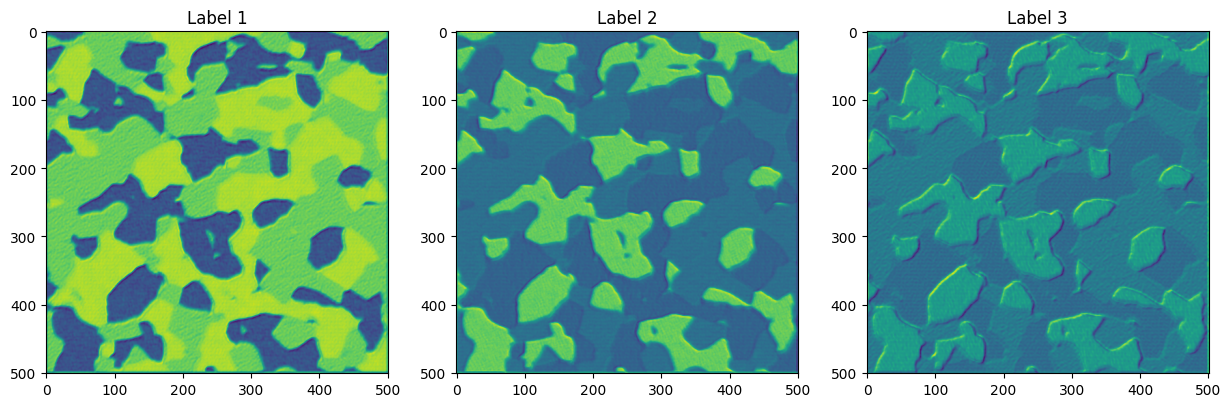

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(im_true[0,:,:].detach().numpy())
axs[0].set_title('Label 1')
axs[1].imshow(im_true[1,:,:].detach().numpy())
axs[1].set_title('Label 2')
axs[2].imshow(im_true[2,:,:].detach().numpy())
axs[2].set_title('Label 3')

